In [1]:
import numpy as np
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns

Data generation

In [2]:
np.random.seed(0)
data = 2*np.random.uniform(size=(10000,2))-1
data

array([[ 0.09762701,  0.43037873],
       [ 0.20552675,  0.08976637],
       [-0.1526904 ,  0.29178823],
       ...,
       [ 0.90710145,  0.49634901],
       [-0.40346677, -0.10708848],
       [-0.27974677,  0.25177329]])

In [3]:
labels = np.zeros((data.shape[0],1))
for i in range(data.shape[0]):
  if data[i][0]*data[i][1] > 0:
    labels[i]=1
  else:
    labels[i]=0

labels

array([[1.],
       [1.],
       [0.],
       ...,
       [1.],
       [1.],
       [0.]])

1. Write a Dataset module for the XOR data (3 sets train, validation and test,70:15:15 respectively)


In [4]:
train_data = data[:6999, :]
test_data = data[7000:8499, :]
val_data = data[8500:9999,:]
train_labels = labels[:6999]
test_labels = labels[7000:8499]
val_labels = labels[8500:9999]

In [5]:
class Xor(Dataset):

  def __init__(self,data,labels) :
    self.data = data
    self.labels = labels

  def __getitem__(self,index) :
    X = self.data[index,:]
    Y = self.labels[index]
    return X,Y

  def __len__(self):
    return self.data.shape[0]

2. Define the Dataloader with batchsize of 16

In [6]:
train_set = Xor(train_data,train_labels)
val_set = Xor(val_data,val_labels)
test_set = Xor(test_data,test_labels)

In [7]:
train_load = DataLoader(train_set, drop_last=False ,batch_size=16, shuffle=True)
test_load = DataLoader(test_set, drop_last=False, batch_size=1500, shuffle=True)
val_load = DataLoader(val_set, drop_last=False, batch_size=16, shuffle=True)  
#Batch_size of test is taken as 1500 so as in final task,  the length remains 1499 for both test and predict 

3. Define the Neural Network Model


In [8]:
class Relu(torch.nn.Module):
  def __init__(self, hidden_layer_size = 4):
    super(Relu,self).__init__()
    self.linear1 = torch.nn.Linear(2, hidden_layer_size)
    self.linear2 = torch.nn.Linear(hidden_layer_size, 1)
  
  def forward(self, x):
    x = torch.nn.functional.relu(self.linear1(x)) 
    out = torch.sigmoid(self.linear2(x)) 
    return out

model = Relu()

4. Define loss function as torch.nn.CrossEntropyLoss

In [9]:
def NN_model(hidden_layer_size=4, learning_rate=0.003, num_epoch = 100):
  model = Relu(hidden_layer_size)
  loss_function = torch.nn.BCELoss(reduction='sum') # we would set mean for the loss
  optimizer = torch.optim.SGD(model.parameters(), learning_rate)

  train_loss = []
  val_loss = []
  train_accuracy = []
  val_accuracy = [] 

  for ind in range(num_epoch):
    tot_train_loss = 0
    tot_train_accuracy = 0
    tot_val_loss = 0
    tot_val_accuracy = 0

    for batch in train_load:
      batch_x = batch[0]
      batch_y = batch[1]
      model.train()
      y_pred = model(batch_x.float())
      loss = loss_function(y_pred.float(),batch_y.float())/16 
      tot_train_loss+=16*loss
      tot_train_accuracy+= ((y_pred>0.5)== batch_y).sum()
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    train_accuracy.append(tot_train_accuracy.detach().numpy()/70)
    train_loss.append(tot_train_loss.detach().numpy()/7000)

    with torch.no_grad():
      model.eval()

      for batch in val_load:
        batch_x = batch[0]
        batch_y = batch[1]
        y_pred_val = model(batch_x.float())
        loss = loss_function(y_pred_val.float(),batch_y.float())
        tot_val_loss+=loss
        tot_val_accuracy+= ((y_pred_val>0.5)== batch_y).sum()

      val_accuracy.append(tot_val_accuracy.detach().numpy()/15)
      val_loss.append(tot_val_loss.detach().numpy()/1500)
  
  return model,train_accuracy,train_loss,val_accuracy,val_loss

In [10]:
hidden_layer_size = 4 
learning_rate = 0.003
num_epoch = 100
mod,train_accuracy,train_loss,val_accuracy,val_loss = NN_model(hidden_layer_size,learning_rate,num_epoch)

(a) Training and Validation loss vs epoch in a single plot

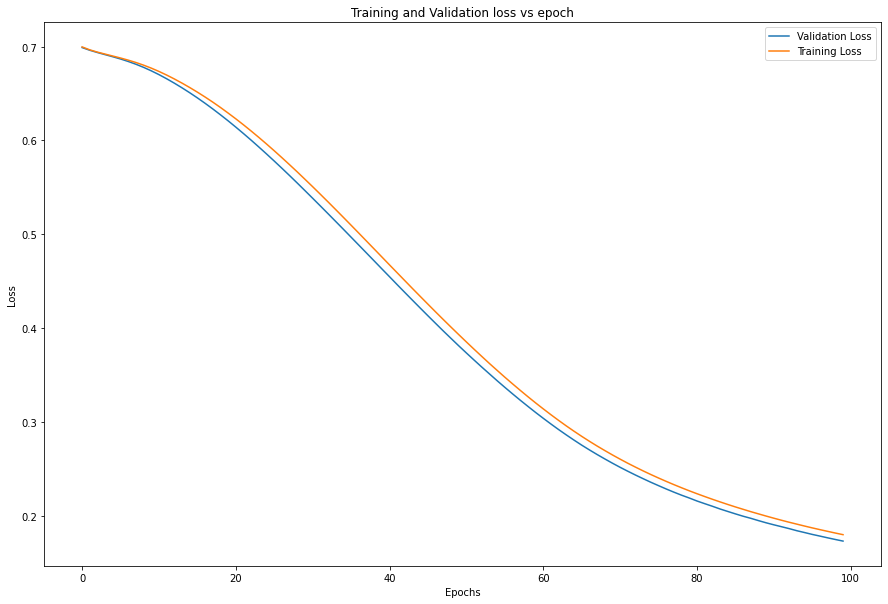

In [11]:
plt.figure(figsize=(15,10))
validation_loss, = plt.plot(val_loss, label = 'Validation Loss')
training_loss, = plt.plot(train_loss, label = 'Training Loss')
plt.title('Training and Validation loss vs epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

(b) Training and Validation accuracy vs epoch in a single plot


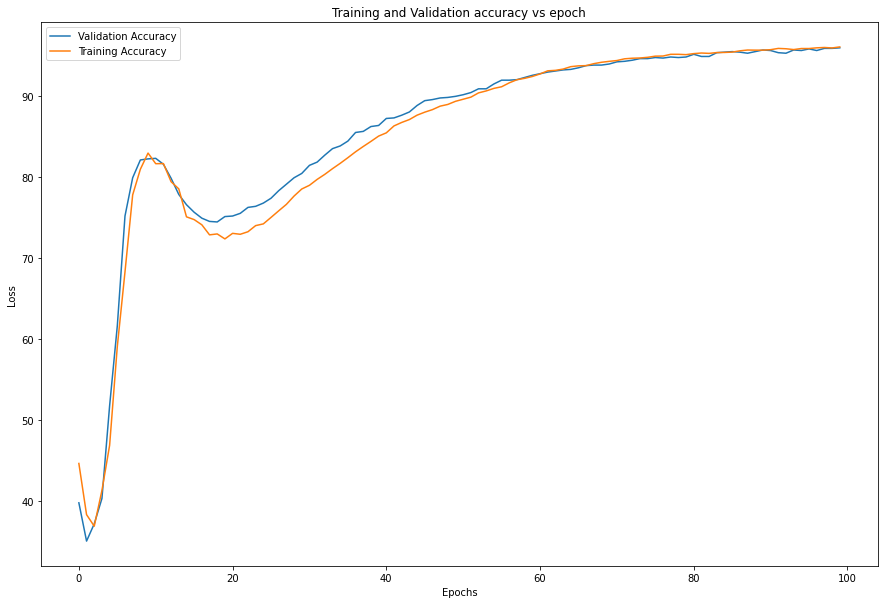

In [12]:
plt.figure(figsize=(15,10))
validation_accuracy, = plt.plot(val_accuracy, label = 'Validation Accuracy')
training_accuracy, = plt.plot(train_accuracy, label = 'Training Accuracy')
plt.title('Training and Validation accuracy vs epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

(c) Best Validation loss vs Hidden Layer size (use hidden size
to be (2,4,6,8,10))

In [13]:
hidden_sizes = [2,4,6,8,10]
best_val_loss = []
best_val_accuracy = []
for hidden_size in hidden_sizes:
  mod,train_accuracy,train_loss,val_accuracy,val_loss = NN_model(hidden_layer_size=hidden_size)
  best_accuracy = max(val_accuracy)
  best_loss = min(val_loss)
  best_val_accuracy.append(best_accuracy)
  best_val_loss.append(best_loss)

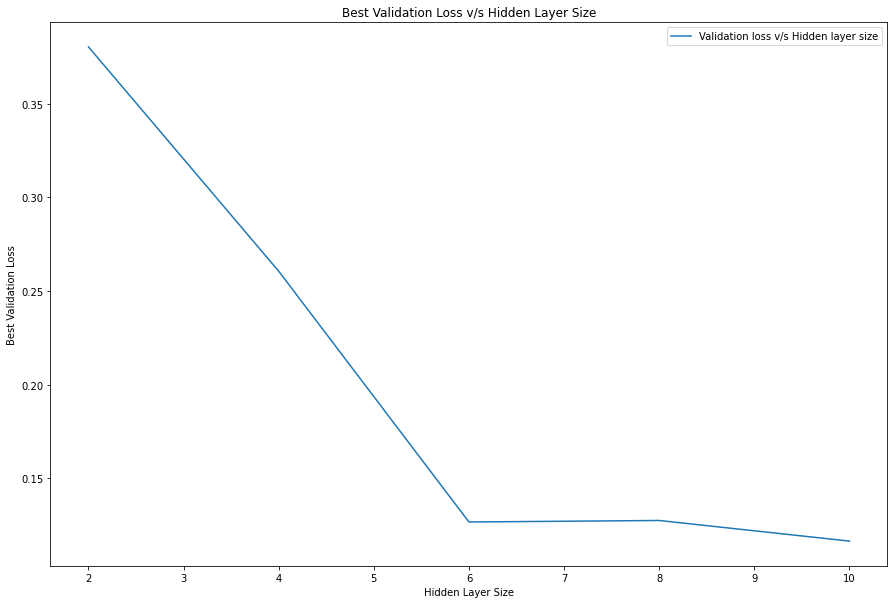

In [14]:
plt.figure(figsize=(15,10))
validation_loss, = plt.plot(hidden_sizes,best_val_loss, label = 'Validation loss v/s Hidden layer size')
plt.title('Best Validation Loss v/s Hidden Layer Size')
plt.xlabel('Hidden Layer Size')
plt.ylabel('Best Validation Loss')
plt.legend()
plt.show()

In [15]:
best_hidden_layer_size = ((best_val_loss.index(min(best_val_loss)))+1)*2
best_hidden_layer_size

10

In [16]:
learning_rates = [1e-1,1e-2,1e-3,1e-4,1e-5]
best_lr_val_loss = []
best_lr_val_accuracy = []
for lr in learning_rates:
  mod,train_accuracy,train_loss,val_accuracy,val_loss = NN_model(num_epoch=20, learning_rate=lr)
  best_accuracy = max(val_accuracy)
  best_loss = min(val_loss)
  best_lr_val_accuracy.append(best_accuracy)
  best_lr_val_loss.append(best_loss)

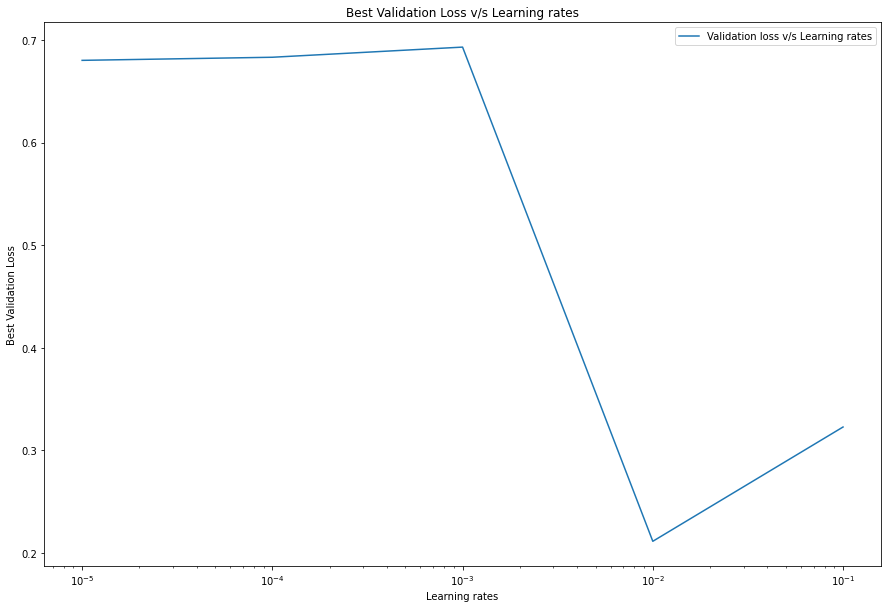

In [17]:
fn,axi = plt.subplots(figsize=(15,10))
validation_loss, = axi.plot(learning_rates,best_lr_val_loss, label = 'Validation loss v/s Learning rates')
axi.set_xscale('log')
plt.title('Best Validation Loss v/s Learning rates')
plt.xlabel('Learning rates')
plt.ylabel('Best Validation Loss')
plt.legend()
plt.show()

In [18]:
best_lr = 10**-((best_lr_val_loss.index(min(best_lr_val_loss)))+1)
best_lr

0.01

best lr = 0.01

(e) Plot test set predicted labels for best validation model.
Report accuracy and loss for the same.

In [19]:
# mod,train_accuracy,train_loss,val_accuracy,val_loss = NN_model(hidden_layer_size=10,learning_rate=0.01,num_epoch=100) 
# TO get the y data from the function I have just written the function content here again and extracted y for plot
hidden_layer_size=best_hidden_layer_size
learning_rate=best_lr
num_epoch=100

model = Relu(hidden_layer_size)
loss_function = torch.nn.BCELoss(reduction='sum') # we would take mean for the loss
optimizer = torch.optim.SGD(model.parameters(), learning_rate)

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = [] 

for ind in range(num_epoch):
  tot_train_loss = 0
  tot_train_accuracy = 0
  tot_test_loss = 0
  tot_test_accuracy = 0

  for batch in train_load:
    batch_x = batch[0]
    batch_y = batch[1]
    model.train()
    y_pred = model(batch_x.float())
    loss = loss_function(y_pred.float(),batch_y.float())/16 
    tot_train_loss+=16*loss
    tot_train_accuracy+= ((y_pred>0.5)== batch_y).sum()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  train_accuracy.append(tot_train_accuracy.detach().numpy()/70)
  train_loss.append(tot_train_loss.detach().numpy()/7000)

  with torch.no_grad():
    model.eval()

    for batch in test_load:
      batch_x = batch[0]
      batch_y = batch[1]
      y_pred_test = model(batch_x.float())
      loss = loss_function(y_pred_test.float(),batch_y.float())
      tot_test_loss+=loss
      tot_test_accuracy+= ((y_pred_test>0.5)== batch_y).sum()

    test_accuracy.append(tot_test_accuracy.detach().numpy()/15)
    test_loss.append(tot_test_loss.detach().numpy()/1500)

y = (y_pred_test>0.5).detach().numpy().astype('int')

In [20]:
print('Accuracy : ' + str(max(test_accuracy)))
print('Loss :' + str(min(test_loss)))

Accuracy : 99.86666666666666
Loss :0.057037317911783854


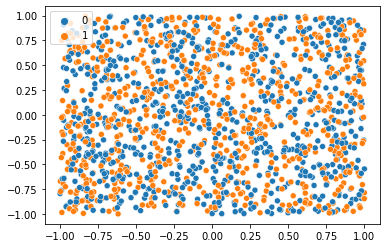

In [21]:
sns.scatterplot(x = test_data[:,0], y =test_data[:,1], hue = y[:,0])